# Импорт библиотек и модулей 

In [25]:
import pandas as pd 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.manifold import TSNE

import re
import nltk
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN

import fasttext
import pymorphy2

import zipfile
import wget
import gensim

from gensim.models import Word2Vec

In [ ]:
#первая предобученая модель
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz
!gunzip cc.ru.300.bin.gz

--2020-12-17 19:29:27--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ru.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4496459151 (4.2G) [application/octet-stream]
Saving to: ‘cc.ru.300.bin.gz.2’

cc.ru.300.bin.gz.2    0%[                    ]  31.25M  9.63MB/s    eta 8m 12s ^C
gzip: cc.ru.300.bin already exists; do you wish to overwrite (y or n)? 

In [26]:
!pip3 install fasttext

In [27]:
!pip install pymorphy2

In [12]:
#инициализация предобученной модели
ft_model = fasttext.load_model('cc.ru.300.bin')

NameError: ignored

In [28]:
morph = pymorphy2.MorphAnalyzer()
bad_pos = {'CONJ', 'PREP', 'NPRO', 'PRCL'}

In [29]:
def clean_text(text):
    text = re.sub(r'[^\w\s]',' ', text)
    text = text.lower()
    clean_text = []
    for word in text.split():
        if not word:
            continue
        if morph.parse(word)[0].tag.POS in bad_pos:
            continue
        word = morph.parse(word)[0].normal_form
        if word not in stop_words:
          clean_text.append(word)
        else:
          continue
    return ' '.join(clean_text)

In [30]:
def get_sentence_vector(sentence):
    vec = np.zeros_like(ft_model.get_word_vector('привет'))
    sentence_split = sentence.split() 
    for word in sentence.split():
        vec += ft_model.get_word_vector(word)
#     return vec / len(sentence_split)
    return vec / np.linalg.norm(vec)

In [42]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words("russian")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
data_path = '2 маски - Разметка.csv'

In [44]:
data = pd.read_csv(data_path, header = None, names = ['comment', 'class'])

# Предобработа данных 

In [34]:
data.head()

,comment,class
0,сделать маски с изображением популярных героев...,супергерой
1,набор для изготовления масок с использованием ...,рисунок
2,сделать маски с принтами животных и супергерое...,супергерой
3,детская маска и конфетка или какой-нибудь пода...,вкус
4,герой мультика или даже супергерой начал носит...,супергерой


In [45]:
data['text_clean'] = data['comment'].map(clean_text)

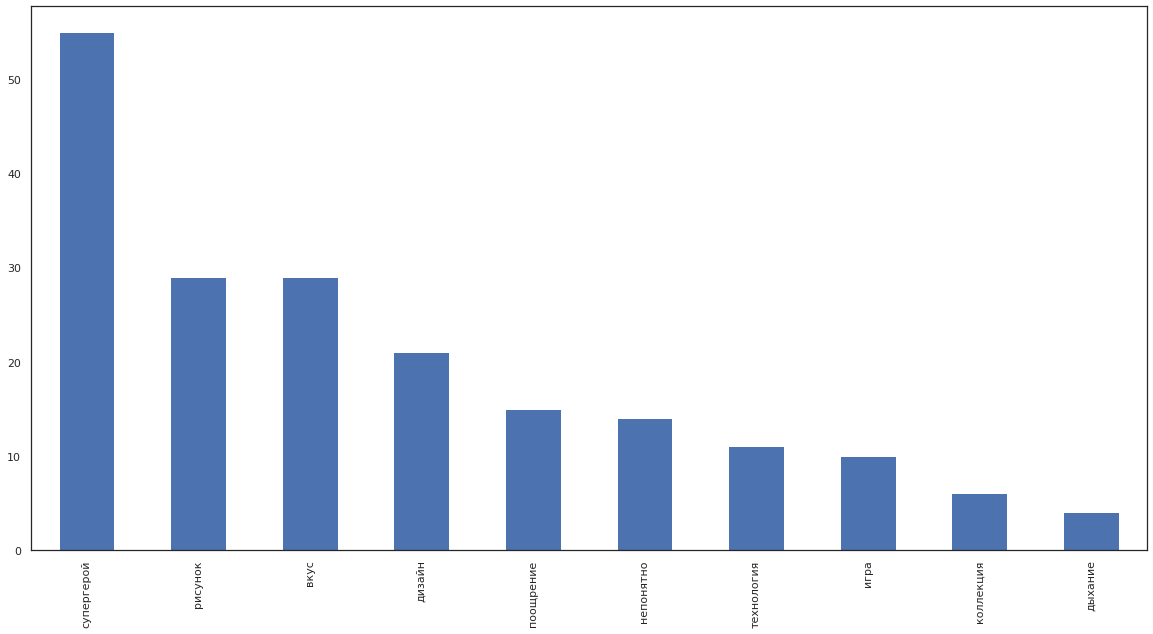

In [36]:
#оценка распределения классов 
plt.figure(figsize=(20,10))
data['class'].value_counts().plot.bar()

Чаще всего оставляют коменты про супергероев. примерно в одной размерности предлагают работать с темами вкус, рисунок и дизайн. Интересно, что именно предлагают сделать со вкусом масок. Можно посмотреть на примеры. 

In [14]:
data[data['class']=='вкус'].sample(5)

,comment,class,text_clean
173,Маски с запахом жвачки,вкус,маска запах жвачка
3,детская маска и конфетка или какой-нибудь пода...,вкус,детский маска конфетка нибыть подарок набор
60,"Маска съедобная, чтобы можно было облизывать и...",вкус,маска съедобный облизывать изнутри
72,Пропитать маски каким-то приятным ароматом (ко...,вкус,пропитать маска приятный аромат конфетный жвач...
56,Маска с соской,вкус,маска соска


То есть категория вкус больше про всякие запахи для масок. Хорошо хоть облизывать не предлагают. 

Вообще реплик довольно мало выходит, поэтому обучать какие-то модели на них - дохлое дело. Разреженные матрицы получаются неинформативными и кластеры не угадываются. Поэтому для извлечения из слов информации лучше взять предобученные модели для русского языка. Например, пойдет предложенная из фасттекста. 

In [15]:
data['vector'] = data['text_clean'].map(get_sentence_vector)

# Кластеризация

Сначала можно взглянуть на расстояние между элементами

In [29]:
#перебор параметров для knn 
knn_params = {'n_neighbors': range(1, 10)}
knn = KNeighborsClassifier(weights='distance')
knn_grid = GridSearchCV(knn, knn_params,
cv=5, n_jobs=-1,
verbose=True)

In [30]:
#вертикальное объединение массивов в 1 большой массив 
vectors = np.vstack(data['vector'].values) 
knn_grid.fit(vectors, np.zeros(len(data)))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    1.5s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='distance'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': range(1, 10)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=True)

In [31]:
knn_grid.best_params_

{'n_neighbors': 1}

In [38]:
knn = KNeighborsClassifier(weights='distance', n_neighbors=1)
knn.fit(vectors, np.zeros(len(data)))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='distance')

In [40]:
query_index = 0
query_label = data['class'].iloc[query_index]

In [47]:
#возвращает дистанцию до n ближайших соседей и индексы точек
distances, indexes = knn.kneighbors(vectors[[query_index]], n_neighbors=len(data))

In [48]:
#сколько раз встречается тестовый класс "супергерой"
support = (data['class'] == query_label).sum()

In [49]:
#55 ближайших соседей 
top_predictions = data['class'].iloc[indexes[0][:support]]

In [50]:
print('Accuracy по в классу для этого предложения:', (top_predictions == query_label).mean())


Accuracy по в классу для этого предложения: 0.6727272727272727


In [51]:
# на размеченных данных получилось около 10 классов, в идеале и кластеров должно быть примерно столько же 
data['class'].nunique()

10

In [52]:
print('Расстояние\tНормализированный текст')
for i, d  in zip(indexes[0], distances[0]):
    print(round(d, 2), data['class'].iloc[i], data['text_clean'].iloc[i], sep='\t')

Расстояние	Нормализированный текст
0.0	супергерой	сделать маска изображение популярный герой массовый культура
0.5	супергерой	маска нарисовать известный детский герой
0.5	супергерой	маска нарисовать любимый герой
0.5	супергерой	маска должный составлять коллекция изображать герой современный мультфильм
0.51	супергерой	создать уникальный маска любимый детский герой
0.53	рисунок	сделать маска рисунок любимый персонаж
0.53	супергерой	маска любимый герой
0.53	супергерой	маска животное любимый герой
0.54	супергерой	паттерн маска любимый герой
0.54	супергерой	мультик главный герой начать носить маска
0.56	супергерой	сделать маска морда животное любимый герой
0.57	супергерой	сделать маска принтами животное супергерой любимый герой мультик
0.59	супергерой	герой мультик супергерой начать носить маска
0.59	супергерой	сделать маска персонаж мультик
0.59	супергерой	мультик герой одевать маска подражание
0.6	супергерой	сделать маска вид часть герой
0.6	супергерой	дорисовывать маска весь персонаж поп

In [75]:
result ={}
for eps in np.arange(0.1, 1, 0.005):
    clustering = DBSCAN(eps=eps, min_samples=3).fit(vectors)
    result[eps]= len(set(clustering.labels_))

In [79]:
max(result.values())

8

In [89]:
#расстояние для лучшего срабатывания DBSCAN
[dist for dist, n in result.items() if n == 8]

[0.5150000000000003, 0.5200000000000004, 0.5250000000000004]

In [90]:
clustering = DBSCAN(eps=0.5200000000000004, min_samples=3).fit(vectors)

In [93]:
clustering.labels_

array([ 0, -1,  0, -1,  0,  0, -1, -1, -1,  4, -1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1,  0,  0, -1, -1,  5, -1, -1, -1,  0, -1,  2, -1, -1, -1,
       -1, -1,  1,  2, -1, -1, -1,  2, -1, -1, -1,  0, -1,  1, -1, -1,  0,
       -1,  1,  0,  0, -1,  3, -1,  4, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1,  4, -1, -1, -1, -1, -1,
       -1,  0,  0,  0,  0,  2,  6,  0, -1, -1, -1, -1,  3, -1,  0,  0, -1,
       -1, -1, -1,  6, -1, -1,  2,  2,  1, -1,  5,  3, -1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  1, -1,  2,
        2,  2, -1, -1, -1, -1, -1, -1, -1, -1,  5, -1,  5, -1, -1, -1,  0,
       -1, -1,  0,  6,  0, -1, -1, -1, -1, -1,  0, -1, -1, -1,  1, -1,  3,
       -1, -1, -1,  1, -1, -1,  1, -1, -1,  0, -1, -1, -1,  0, -1, -1, -1,
       -1, -1,  2, -1, -1, -1, -1])

In [94]:
data['pred'] = clustering.labels_

## Визуализация

In [96]:
tsne = TSNE()
xy = tsne.fit_transform(vectors)

In [113]:
pca = PCA()
pca_m = pca.fit_transform(vectors)

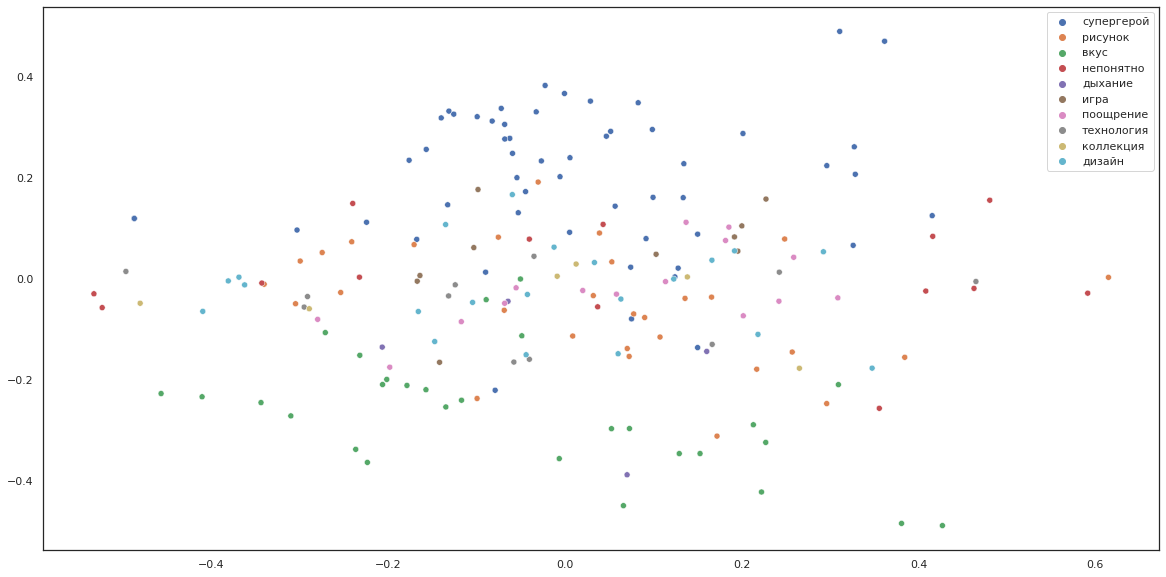

In [114]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=pca_m[:,0], y=pca_m[:,1], hue=data['class'].values)

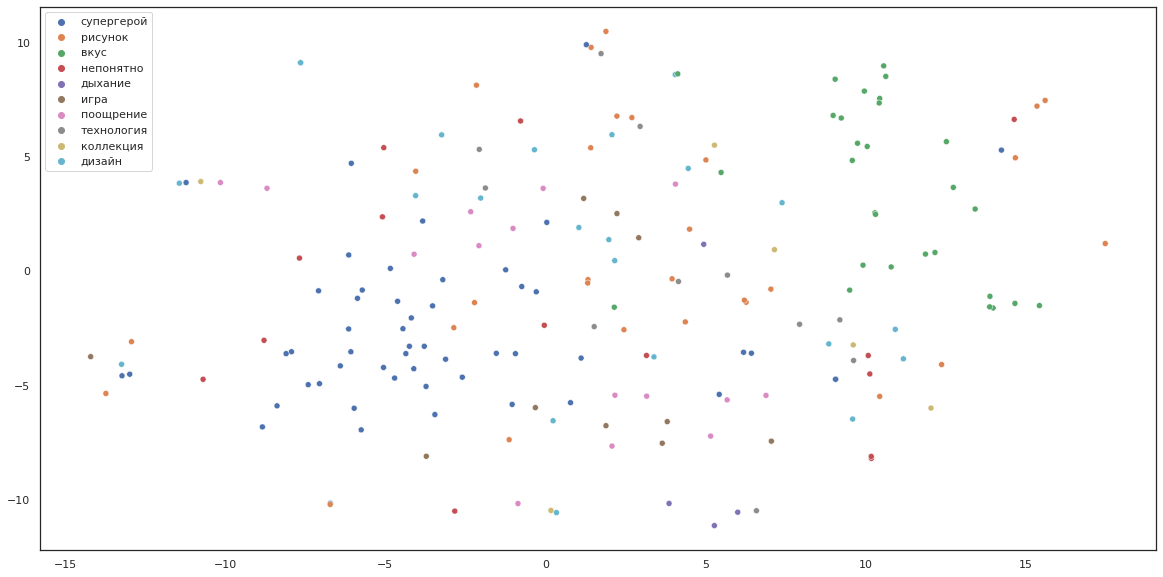

In [98]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=xy[:,0], y=xy[:,1], hue=data['class'].values)

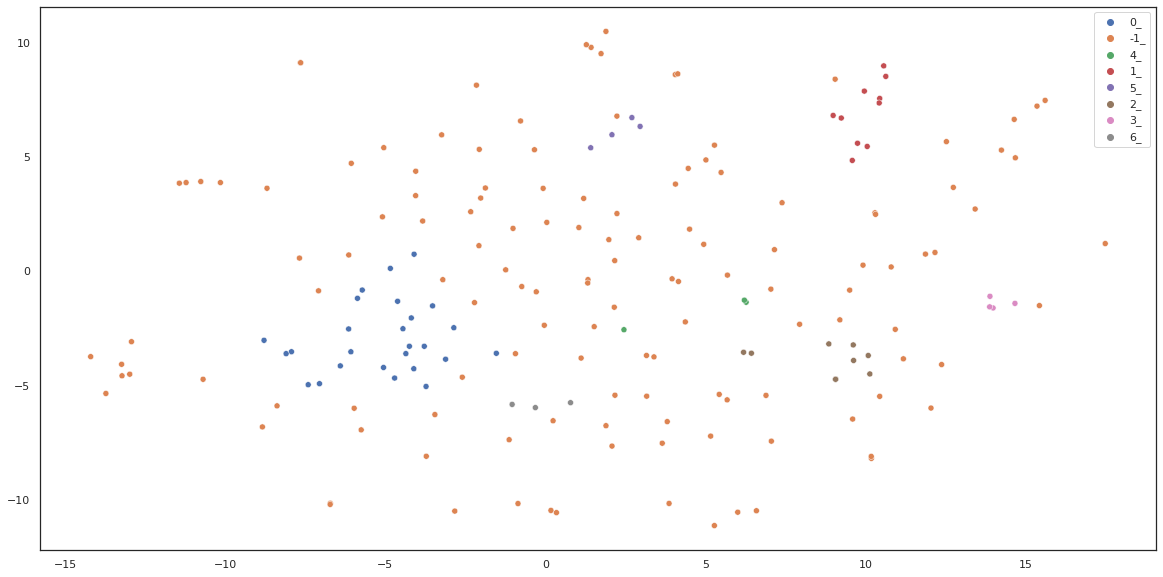

In [101]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=xy[:,0], y=xy[:,1], hue=data['pred'].map(lambda x: str(x) + '_').values)

In [102]:
v_measure_score(data['class'], data['pred'])

0.2470066317506473

In [103]:
y = data['class']

кластеров - 1, метрика - 1.7541242171112808e-16
кластеров - 2, метрика - 0.01345531520454395
кластеров - 3, метрика - 0.15828054977937955
кластеров - 4, метрика - 0.2504989666999638
кластеров - 5, метрика - 0.24728192881121278
кластеров - 6, метрика - 0.2427843172060468
кластеров - 7, метрика - 0.2685698954071026
кластеров - 8, метрика - 0.251676826401111
кластеров - 9, метрика - 0.2899810981395082
кластеров - 10, метрика - 0.32382827986734863
кластеров - 11, метрика - 0.30403489220272795


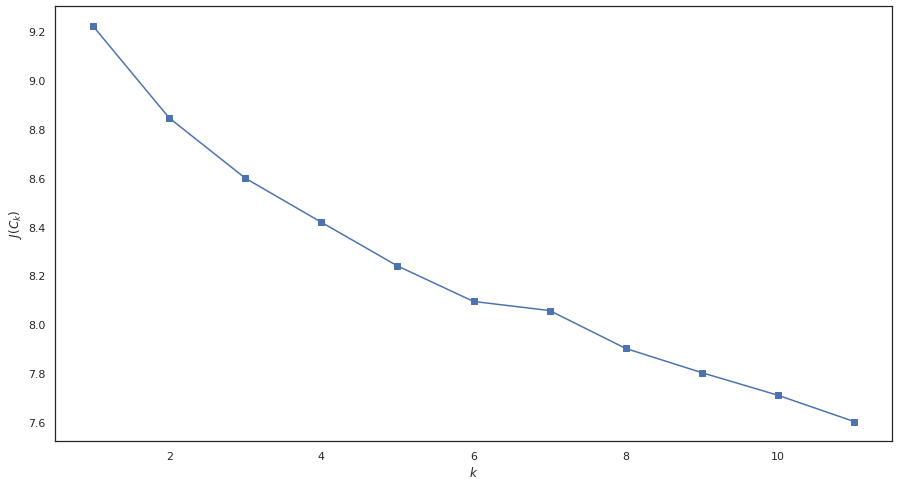

In [104]:
inertia = []
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(vectors)
    inertia.append(np.sqrt(kmeans.inertia_))
    result = v_measure_score(y, kmeans.predict(vectors))
    print(f'кластеров - {k}, метрика - {result}')

plt.figure(figsize = (15,8))
plt.plot(range(1, 12), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

А вот если смотреть на алгоритм k-means, то результат сильно лучше получается, особенно при 10 кластерах. 

In [105]:
kmeans = KMeans(n_clusters=10, random_state=1).fit(vectors)

In [107]:
kmeans.labels_

array([0, 2, 0, 1, 0, 0, 7, 1, 5, 1, 1, 6, 7, 0, 8, 3, 8, 3, 2, 8, 0, 0,
       2, 1, 2, 1, 8, 4, 0, 7, 1, 3, 3, 8, 8, 0, 6, 1, 7, 1, 4, 1, 6, 7,
       8, 0, 8, 6, 0, 0, 0, 5, 6, 0, 0, 1, 9, 6, 1, 4, 7, 8, 2, 1, 1, 6,
       1, 7, 8, 1, 3, 5, 6, 8, 3, 3, 0, 3, 7, 1, 8, 3, 3, 1, 8, 0, 1, 0,
       0, 3, 1, 8, 0, 8, 8, 2, 3, 9, 7, 0, 0, 8, 0, 8, 3, 0, 8, 0, 1, 1,
       6, 2, 2, 9, 3, 2, 6, 8, 2, 3, 8, 3, 2, 1, 2, 3, 2, 4, 2, 2, 2, 8,
       0, 6, 1, 1, 1, 1, 2, 5, 0, 1, 5, 8, 4, 4, 2, 8, 2, 0, 3, 8, 0, 3,
       8, 0, 8, 0, 3, 3, 2, 2, 8, 0, 7, 5, 8, 6, 1, 9, 0, 1, 2, 6, 8, 3,
       6, 9, 6, 0, 8, 2, 1, 0, 2, 0, 3, 7, 5, 1, 7, 3, 8, 3], dtype=int32)

In [108]:
data['pred_kmeans'] = kmeans.labels_

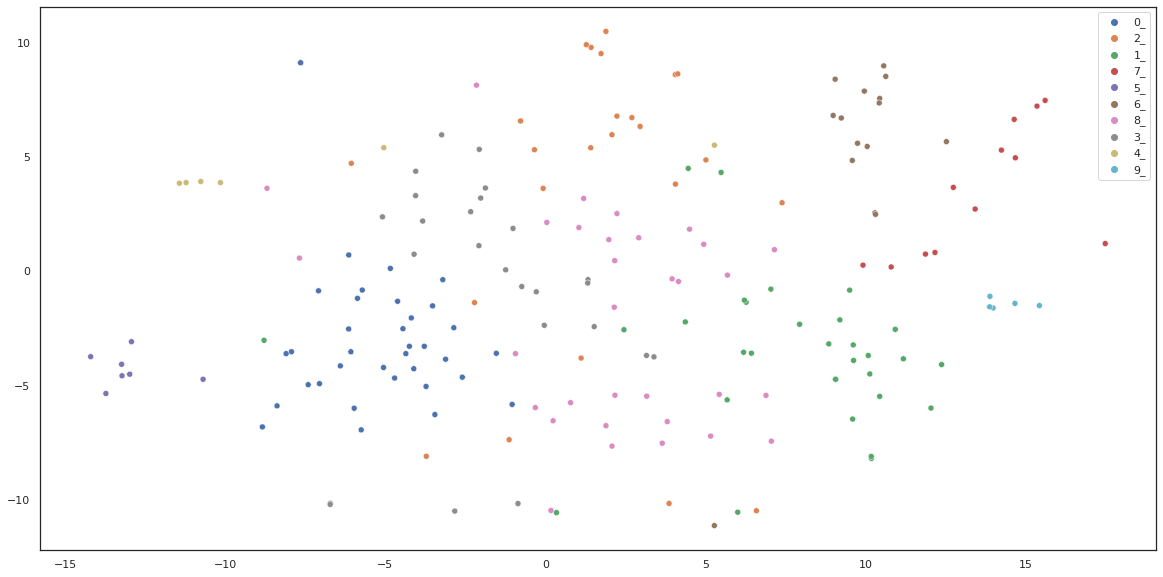

In [109]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=xy[:,0], y=xy[:,1], hue=data['pred_kmeans'].map(lambda x: str(x) + '_').values)

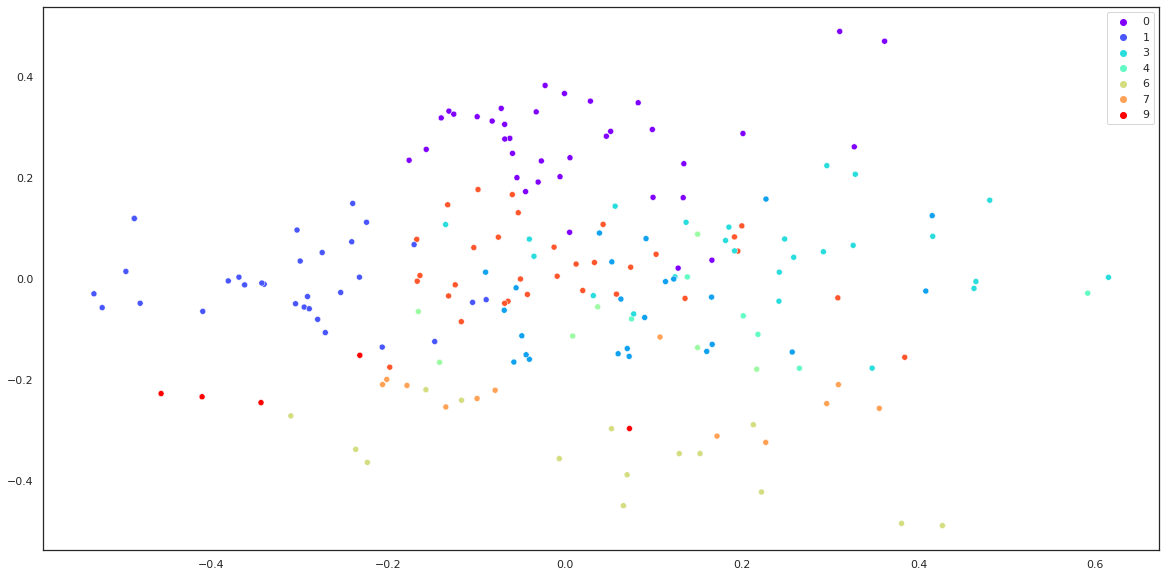

In [121]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=pca_m[:,0], y=pca_m[:,1], hue=data['pred_kmeans'].values,  palette = 'rainbow')

На K-means действительно получается лучше кластеризовать этот текст. 
Особенно хорошо это прослеживается на данных, прогнанных через PCA.

In [122]:
agglo1 = AgglomerativeClustering(n_clusters = 10, affinity='euclidean')

In [128]:
agglo1.fit(vectors)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=10)

In [129]:
agglo1.labels_

array([5, 4, 5, 4, 5, 5, 0, 1, 0, 1, 2, 7, 3, 5, 1, 9, 1, 1, 9, 9, 5, 5,
       4, 2, 4, 2, 9, 9, 5, 3, 2, 9, 9, 5, 9, 5, 7, 2, 3, 1, 6, 2, 4, 1,
       1, 5, 9, 7, 0, 3, 5, 0, 7, 5, 5, 9, 8, 1, 1, 6, 1, 1, 4, 2, 2, 1,
       4, 1, 1, 4, 1, 0, 3, 1, 9, 9, 5, 1, 3, 1, 1, 9, 1, 2, 1, 0, 5, 5,
       5, 9, 2, 1, 5, 1, 1, 4, 9, 8, 1, 5, 5, 1, 5, 9, 9, 1, 5, 0, 2, 2,
       7, 4, 4, 8, 9, 1, 7, 9, 4, 9, 2, 9, 9, 2, 9, 9, 1, 6, 4, 4, 9, 1,
       5, 7, 2, 2, 2, 2, 4, 0, 5, 2, 0, 2, 6, 9, 4, 1, 4, 5, 9, 1, 9, 9,
       2, 5, 1, 5, 9, 9, 4, 1, 1, 5, 3, 0, 1, 7, 2, 8, 5, 4, 4, 7, 1, 9,
       7, 8, 7, 5, 9, 4, 2, 5, 1, 9, 9, 3, 0, 2, 3, 1, 1, 9])

In [130]:
v_measure_score(y, agglo1.labels_)

0.2932542926698803

# Проба другой предобученной модели


In [9]:
!pip3 install wget

In [11]:
!pip3 install gensim

In [75]:

model_url = 'http://vectors.nlpl.eu/repository/20/65.zip'
m = wget.download(model_url)
model_file = model_url.split('/')[-1]
with zipfile.ZipFile(model_file, 'r') as archive:
    stream = archive.open('model.bin')
    model = gensim.models.KeyedVectors.load_word2vec_format(stream, binary=True)

In [80]:
def get_sentence_vector_second(sentence):
    vec = np.zeros_like(model.word_vec('привет'))
    sentence_split = sentence.split() 
    for word in sentence.split():
      try:
        vec += model.word_vec(word)
      except:
        continue
#     return vec / len(sentence_split)
    return vec / np.linalg.norm(vec)

In [81]:
data['vector_second'] = data['text_clean'].map(get_sentence_vector_second)

In [82]:
second_vectors =  np.vstack(data['vector_second'].values) 

In [83]:
kmeans = KMeans(n_clusters=10, random_state=1).fit(second_vectors)

In [85]:
v_measure_score(data['class'], kmeans.labels_)

0.330260573431447

In [97]:
data['s_k_pred'] = kmeans.labels_

In [89]:
tsne = TSNE()
xy = tsne.fit_transform(second_vectors)

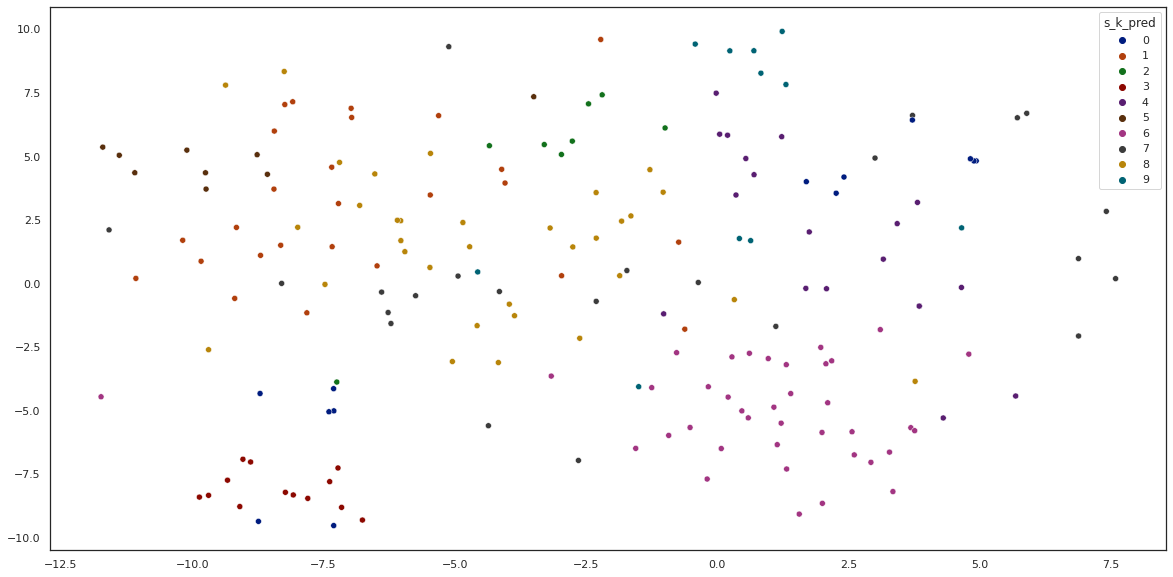

In [101]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=xy[:,0], y=xy[:,1], hue=data['s_k_pred'], palette = 'dark')

In [93]:
pca = PCA()
pca_m = pca.fit_transform(second_vectors)

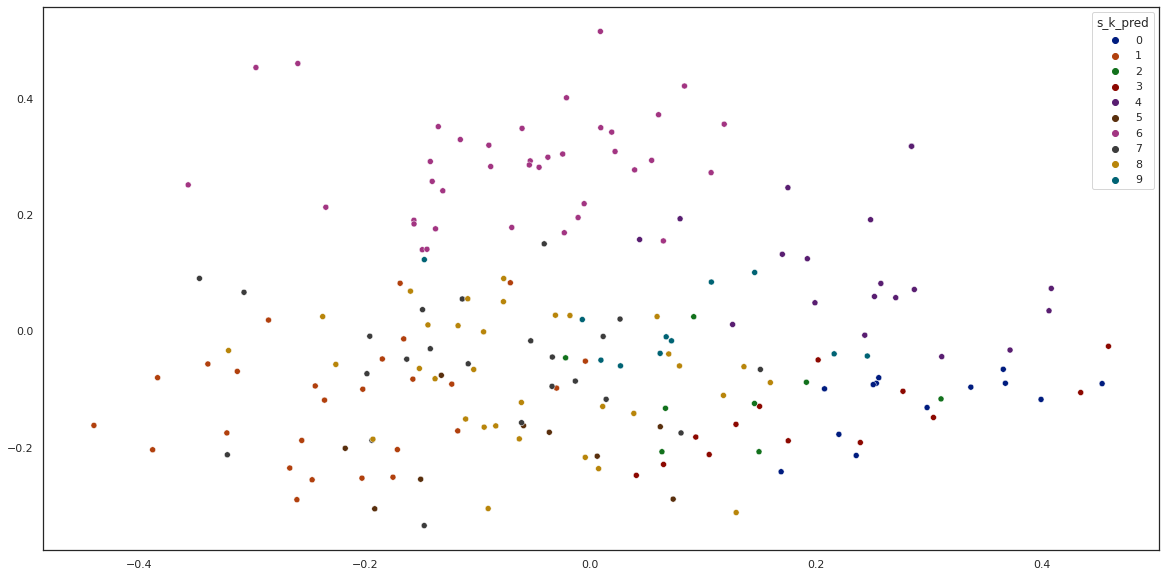

In [102]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x=pca_m[:,0], y=pca_m[:,1], hue=data['s_k_pred'],  palette = 'dark')